[]

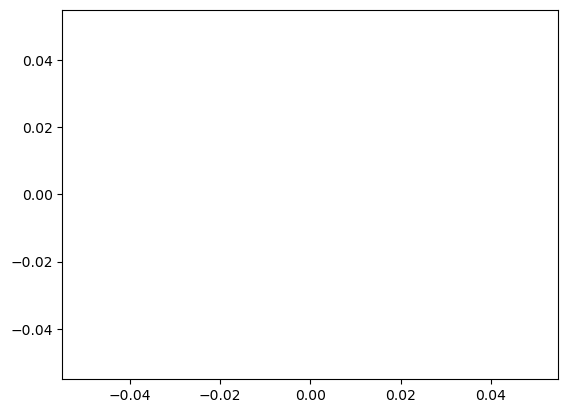

In [1]:
import matplotlib.pyplot as plt
plt.plot()

In [2]:
from gensim.models import FastText
import spacy
import re
import numpy as np
import torch
import os
import torch.nn as nn
from torch import optim
import dash
from dash import dcc, html
from dash.dependencies import Input, Output, State
import numpy as np
import plotly.graph_objs as go
import plotly.express as px
import pandas as pd
import random
from collections import defaultdict
import base64
from io import BytesIO
from wordcloud import WordCloud
from collections import Counter
import ast

In [3]:
class RNN_attention(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, prob=0.5):
        super().__init__()

        # Automatically choose device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.hidden_dim = hidden_dim
        self.input_size = input_size
        self.n_layers = n_layers

        # LSTM layer
        self.rnn = nn.LSTM(input_size, hidden_dim, n_layers, dropout=prob, batch_first=True)

        # Attention 
		
        # 1st Layer: Input = Queries + Hidden State
        self.linear1 = nn.Linear(2*hidden_dim,hidden_dim)
        self.tanh = nn.Tanh()
        # 2nd Layer: Output = 1 (Sum of the Normalized weights * keys)
        self.linear2 = nn.Linear(hidden_dim,1)
        self.softmax = nn.Softmax(dim = 1)

        # Fully-connected output layer
        self.fc1 = nn.Linear(hidden_dim, output_size)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(p=prob)

        # Move all layers to the selected device
        self.to(self.device)

    def forward(self, x, lengths, h0=None):

        lengths = [min(l, 35) for l in lengths]

        batch_size = x.size(0)
        seq_length = x.size(1)

        x = x.to(self.device)
        if h0 is not None:
            h0 = (h0[0].to(self.device), h0[1].to(self.device))

        # Compute the RNN output (sequence of states for the whole input) h to hl

        r_out, _ = self.rnn(x, h0)

        # Query (Should be Hidden State l before junk tokens)

        queries = torch.stack([r_out[d, lengths[d] - 1, :] for d in range(batch_size)])
        keys = r_out

        queries = queries.unsqueeze(1)
        queries_expanded = queries.expand(-1, keys.size(1), -1) # Shape: (N, S, H)
        queries_flat = queries_expanded.reshape(-1, keys.size(2))
        keys_flat = keys.reshape(-1, keys.size(2))
        inputs = torch.cat([queries_flat, keys_flat], dim=1)

        unnormalized_weights = self.tanh(self.linear1(inputs))
        unnormalized_weights = self.linear2(unnormalized_weights).squeeze(-1) # Now shape is (N*S,)		
        unnormalized_weights = unnormalized_weights.view(batch_size, seq_length) # Now shape is (N,S)

        mask = torch.arange(seq_length, device=self.device).unsqueeze(0) >= torch.tensor(lengths, device=self.device).unsqueeze(1)
        unnormalized_weights.masked_fill_(mask, float('-inf'))
     
        alphas = self.softmax(unnormalized_weights)
        alphas_expanded = alphas.unsqueeze(-1).expand(-1, -1, keys.size(2))

        c = torch.sum(alphas_expanded * keys, dim=1)
        output = self.logsoftmax(self.fc1(self.dropout(c)))

        return output, alphas


class RNN_attention_with_train(RNN_attention):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, prob=0.0,
                 batch_size=50, lr=0.0005, saved_files='./saved_models/RNN_sentiment_analysis'):
        super().__init__(input_size, output_size, hidden_dim, n_layers, prob)

        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.criterion = nn.NLLLoss()
        self.loss_during_training = []
        self.valid_loss_during_training = []
        self.batch_size = batch_size
        os.makedirs(os.path.dirname(saved_files), exist_ok=True)
        self.saved_files = saved_files

   
    def predict_proba(self, docs, lengths, Y=None):
        accuracy = 0.0
        with torch.no_grad():
            x_input = torch.stack([torch.tensor(d, dtype=torch.float32) for d in docs]).to(self.device)
            logprobs, weights = self.forward(x_input, lengths)
            logprobs = logprobs.cpu().detach().numpy()

            if Y is not None and len(Y) > 0:
                accuracy = np.sum(np.argmax(logprobs, 1) == Y) / np.shape(Y)[0]

        return logprobs, accuracy


    def fit(self, docs_train, docs_val, Y, Yval, len_train, len_val, epochs=100, print_every=5):
        self.print_every = print_every
        self.epochs = epochs
        self.num_train = len(docs_train)
        self.num_batchs = int(np.floor(self.num_train / self.batch_size))
        self.num_val = len(docs_val)
        self.num_batchs_val = int(np.floor(self.num_val / self.batch_size))
    
        labels = torch.tensor(Y, dtype=torch.long, device=self.device)
        labelsval = torch.tensor(Yval, dtype=torch.long, device=self.device)
    
        for e in range(self.epochs):
            self.train()
            idx = np.random.permutation(self.num_train)
            running_loss = 0.
            start_time = time.time()
    
            for i in range(self.num_batchs):
                self.optim.zero_grad()
                idx_batch = idx[i * self.batch_size:(i + 1) * self.batch_size]
                idx_batch = [d for d in idx_batch if len_train[d] > 0]
    
                # Convert docs to tensors
                x_input = torch.stack([torch.tensor(docs_train[d], dtype=torch.float32) for d in idx_batch]).to(self.device)
                out, _ = self.forward(x_input, [len_train[d] for d in idx_batch])
                loss = self.criterion(out, labels[idx_batch])
                running_loss += loss.item()
                loss.backward()
                nn.utils.clip_grad_norm_(self.parameters(), 2.0)
                self.optim.step()
    
            self.loss_during_training.append(running_loss / self.num_batchs)
            torch.save(self.state_dict(), self.saved_files + f'_epoch_{e}.pth')
    
            # Validation
            self.eval()
            with torch.no_grad():
                running_loss = 0.
                idx = np.random.permutation(self.num_val)
                for i in range(self.num_batchs_val):
                    idx_batch = idx[i * self.batch_size:(i + 1) * self.batch_size]
                    idx_batch = [d for d in idx_batch if len_val[d] > 0]
    
                    # Convert docs to tensors for validation
                    x_input = torch.stack([torch.tensor(docs_val[d], dtype=torch.float32) for d in idx_batch]).to(self.device)
                    out, _ = self.forward(x_input, [len_val[d] for d in idx_batch])
                    loss = self.criterion(out, labelsval[idx_batch])
                    running_loss += loss.item()
    
                self.valid_loss_during_training.append(running_loss / self.num_batchs_val)
    
            if (e+1) % self.print_every == 0:
                print(f"============================ Epoch: {e + 1}, Time: {time.time() - start_time} ============================")
                print(f"Training Loss = {self.loss_during_training[-1]}  |  Validation Loss = {self.valid_loss_during_training[-1]}")


In [4]:
model = FastText.load("fasttext.ftz")

In [5]:
nlp = spacy.load("en_core_web_md", disable=["parser","ner"])
def preprocess(text):
    # Delete expressions
    text = re.sub(r"http\S+|@\S+","", text)
    # Turn into lowecases
    text = text.lower()
    # SpaCy preprocessing
    doc = nlp(text)
    tokens = [
        token.lemma_ for token in doc
        if not token.is_stop
        and not token.is_punct
        and token.is_alpha
    ]
    return tokens

In [37]:
def get_fasttext_embeddings(model, sentence, garbage_token, maxlen=35):
    vector_size = model.vector_size
    garbage_vector = model.wv[garbage_token.text] if garbage_token.text in model.wv else np.zeros(vector_size)

    sentence_vectors = [model.wv[word] for word in sentence]

    if len(sentence_vectors) < maxlen:
        pad_len = maxlen - len(sentence_vectors)
        sentence_vectors.extend([garbage_vector] * pad_len)
    else:
        sentence_vectors = sentence_vectors[:maxlen]
        

    return np.array(sentence_vectors)

In [7]:
fasttext_RNN = RNN_attention_with_train(input_size=200, output_size=6, hidden_dim=64, n_layers=4)
fasttext_RNN.load_state_dict(torch.load('fasttextmodel.pth'))

C:\Users\iqbal\AppData\Local\Temp\ipykernel_20268\747756171.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fasttext_RNN.load_state_dict(torch.load('fasttextmodel.pth'))

<All keys matched successfully>

In [26]:
label_to_sentiment = {
    0: 'Sadness',
    1: 'Joy',
    2: 'Love',
    3: 'Anger',
    4: 'Fear',
    5: 'Surprise'
}

garbage_token = nlp("#")

In [36]:
def safe_parse(val):
    if isinstance(val, str):
        try:
            return ast.literal_eval(val)
        except Exception:
            return None
    elif isinstance(val, list):
        return val
    else:
        return None

num_topics = len(df_topic_text["Topic Distribution"].iloc[0])

In [21]:
# Load dataset
redditData = pd.read_csv("redditDataInference.csv", parse_dates=["date"], index_col=0)
df_topic_text = pd.read_csv("reddit_lda_results.csv", index_col=0)
df_topic_text["Topic Distribution"] = df_topic_text["Topic Distribution"].apply(safe_parse)

topic_keywords = pd.read_csv("topic_keywords.csv")

In [35]:
# Group tokens by sentiment
emotion_words = defaultdict(list)

for _, row in redditData.iterrows():
    if isinstance(row['tokens_english'], str):
        tokens = eval(row['tokens'])
    else:
        tokens = row['tokens']
    emotion_words[row['sentiment']].extend(tokens)

sentiment_options = list(emotion_words.keys())

In [15]:
def generate_wordcloud_topic(topic_id, topic_keywords):

    if topic_id in topic_keywords['Topic'].values:
        topic_row = topic_keywords[topic_keywords['Topic'] == topic_id]

        if not topic_row.empty:
            word_columns = [col for col in topic_row.columns if col.startswith('Word_')]
            words = topic_row[word_columns].iloc[0].values

            word_freq = {word: (len(words) - i) for i, word in enumerate(words) if pd.notna(word)}

            if not word_freq:
                print(f"No valid words found for topic ID {topic_id}. Cannot generate wordcloud.")
                return None

            wc = WordCloud(width=600, height=400, background_color='white', collocations=False).generate_from_frequencies(word_freq)

            img = BytesIO()
            plt.figure(figsize=(8, 5)) # Adjusted figure size

            wordcloud_image_array = wc.to_array()
            plt.imshow(wordcloud_image_array, interpolation='bilinear')

            plt.axis('off') # Hide axes
            plt.tight_layout(pad=0) # Reduced padding around the plot
            plt.savefig(img, format='png')

            plt.close()
            img.seek(0)

            return base64.b64encode(img.getvalue()).decode()
        else:
            print(f"Topic ID {topic_id} found in values but no corresponding row.")
            return None
    else:
        print(f"Topic ID {topic_id} not found in topic_keywords.")
        return None 


In [38]:
external_stylesheets = ['https://cdnjs.cloudflare.com/ajax/libs/font-awesome/6.4.0/css/all.min.css']
custom_color_palette = px.colors.qualitative.Bold

colors = {
    'background': '#f9f9f9',
    'card_background': '#ffffff',
    'primary': '#4361ee',
    'secondary': '#3f37c9',
    'text': '#333333',
    'border': '#e0e0e0',
    'highlight': '#4cc9f0',
    'sadness': '#4895ef',
    'joy': '#ffd166',
    'love': '#06d6a0',
    'anger': '#ef476f',
    'fear': '#9d4edd',
    'surprise': '#48cae4'
}

emotion_colors = {
    'sadness': colors['sadness'],
    'joy': colors['joy'],
    'love': colors['love'],
    'anger': colors['anger'],
    'fear': colors['fear'],
    'surprise': colors['surprise']
}

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

card_style = {
    'backgroundColor': colors['card_background'],
    'padding': '15px',
    'marginBottom': '15px'
}

section_header_style = {
    'backgroundColor': colors['primary'],
    'color': 'white',
    'padding': '10px'
}

button_style = {
    'backgroundColor': colors['primary'],
    'color': 'white',
    'border': 'none',
    'padding': '8px 12px'
}

app.layout = html.Div([
    # Header
    html.Div([
        html.H1("Sentiment Analysis & Topic Modeling Dashboard", 
                style={'textAlign': 'center', 'color': colors['text']}),
        html.P("Analyze emotions and topics from Reddit data",
               style={'textAlign': 'center', 'color': colors['secondary']})
    ]),
    
    # PART 1: SENTIMENT CLASSIFIER
    html.Div([
        html.Div([
            html.I(className="fas fa-heart", style={'marginRight': '10px'}),
            html.H2("Part 1: Sentiment Classifier")
        ], style=section_header_style),
        
        html.Div([
            html.Div([
                html.H3("Analyze Your Text", style={'color': colors['primary']}),
                html.P("Enter a sentence to classify its emotional sentiment"),
                
                dcc.Input(
                    id='input-sentence',
                    type='text',
                    placeholder='Enter a sentence...',
                    style={'width': '70%', 'padding': '8px'}
                ),
                
                html.Button(
                    'Classify', 
                    id='classify-button', 
                    n_clicks=0,
                    style=button_style
                ),
                
                html.Div(id='output-label', style={
                    'marginTop': '15px',
                    'padding': '10px',
                    'backgroundColor': colors['highlight'] + '20'
                }),
            ]),
            
            html.Div([
                html.H3("Sentiment Attention Weights", style={'color': colors['primary']}),
                html.P("Visualize how the model weighs different words in your input"),
                
                dcc.Graph(
                    id='attention-weights-graph',
                    figure=go.Figure().update_layout(
                        template='plotly_white',
                        plot_bgcolor=colors['card_background'],
                        paper_bgcolor=colors['card_background']
                    )
                )
            ])
        ], style=card_style)
    ]),
    
    html.Div([
        html.Div([
            html.I(className="fas fa-chart-pie", style={'marginRight': '10px'}),
            html.H2("Part 2: Reddit Emotion Analysis")
        ], style=section_header_style),
        
        html.Div([
            html.Div([
                html.H3("Select Date Range", style={'color': colors['primary']}),
                html.P("Filter Reddit data by date range"),
                
                dcc.DatePickerRange(
                    id='date-picker',
                    min_date_allowed=redditData['date'].min().date(),
                    max_date_allowed=redditData['date'].max().date(),
                    start_date=redditData['date'].min().date(),
                    end_date=redditData['date'].max().date(),
                    updatemode='bothdates'
                ),
            ]),
            
            html.Div([
                html.Div([
                    dcc.Graph(
                        id='emotion-pie',
                        figure=px.pie(title='Emotion Distribution').update_layout(
                            template='plotly_white',
                            plot_bgcolor=colors['card_background'],
                            paper_bgcolor=colors['card_background']
                        )
                    )
                ], style={'width': '48%', 'display': 'inline-block'}),
                
                html.Div([
                    dcc.Graph(
                        id='emotion-bar',
                        figure=px.bar(title='Emotion Counts').update_layout(
                            template='plotly_white',
                            plot_bgcolor=colors['card_background'],
                            paper_bgcolor=colors['card_background']
                        )
                    )
                ], style={'width': '48%', 'display': 'inline-block', 'marginLeft': '4%'})
            ]),
            
            html.Div([
                html.H3("Sample Post", style={'color': colors['primary']}),
                html.P("Click on an emotion in the pie chart to see a random post with that emotion"),
                
                html.Div(id='random-text', style={
                    'padding': '10px',
                    'border': f'1px solid {colors["border"]}',
                    'backgroundColor': colors['highlight'] + '10'
                })
            ]),
            
            html.Div([
                html.H3("Emotion Trends Over Time", style={'color': colors['primary']}),
                
                dcc.Graph(
                    id='emotion-time-series',
                    figure=px.line(title='Emotion Trends Over Time (Weekly)').update_layout(
                        template='plotly_white',
                        plot_bgcolor=colors['card_background'],
                        paper_bgcolor=colors['card_background']
                    )
                )
            ]),
            
            html.Div([
                html.H3("Word Clouds by Emotion", style={'color': colors['primary']}),
                html.P("Select an emotion to view its most common words"),
                
                dcc.Dropdown(
                    id='sentiment-dropdown',
                    options=[{'label': s.capitalize(), 'value': s} for s in sentiment_options],
                    value=sentiment_options[0],
                    clearable=False,
                    style={'width': '200px'}
                ),
                
                html.Div([
                    html.Img(
                        id='wordcloud-image',
                        style={'maxWidth': '100%'}
                    )
                ], style={'textAlign': 'center'})
            ])
        ], style=card_style)
    ]),
    
    # PART 3: TOPIC MODELING
    html.Div([
        html.Div([
            html.I(className="fas fa-comments", style={'marginRight': '10px'}),
            html.H2("Part 3: Topic Modeling")
        ], style=section_header_style),
        
        html.Div([
            html.Div([
                html.H3("Topic Distribution Overview", style={'color': colors['primary']}),
                html.P("Histogram showing the distribution of predominant topics across documents"),
                
                dcc.Graph(
                    figure=px.histogram(
                        df_topic_text,
                        x="Document Index",
                        color="Predominant Topic",
                        title="Predominant LDA Topic Distribution",
                        color_discrete_sequence=custom_color_palette,
                        category_orders={"Predominant Topic": sorted(df_topic_text["Predominant Topic"].unique())},
                    ) if not df_topic_text.empty else go.Figure().update_layout(
                        title="Predominant LDA Topic Distribution (No data)"
                    ).update_layout(
                        template='plotly_white',
                        plot_bgcolor=colors['card_background'],
                        paper_bgcolor=colors['card_background']
                    )
                )
            ]),
            
            html.Div([
                html.H3("Document Explorer", style={'color': colors['primary']}),
                html.P("Select a document index to view its details"),
                
                html.Div([
                    dcc.Input(
                        id='document-index',
                        type='number',
                        min=0,
                        max=len(df_topic_text)-1,
                        value=0,
                        style={'width': '100px', 'padding': '8px'}
                    ),
                    
                    html.Button(
                        'Load Document Info',
                        id='submit-button',
                        n_clicks=0,
                        style=button_style
                    )
                ], style={'marginBottom': '15px'}),
                
                html.Div([
                    html.Div([
                        html.H4("Document Information", style={'color': colors['primary']}),
                        html.Div(
                            id='document-info',
                            style={'padding': '10px', 'border': f'1px solid {colors["border"]}'}
                        )
                    ], style={'width': '48%', 'display': 'inline-block'}),
                    
                    html.Div([
                        html.H4("Document Text", style={'color': colors['primary']}),
                        html.Div(
                            id='document-text',
                            style={'padding': '10px', 'border': f'1px solid {colors["border"]}', 'maxHeight': '200px', 'overflow': 'auto'}
                        )
                    ], style={'width': '48%', 'display': 'inline-block', 'marginLeft': '4%'})
                ]),
                
                html.Div([
                    html.H4("Topic WordCloud", style={'color': colors['primary']}),
                    html.P("Visual representation of keywords for the selected topic"),
                    
                    html.Div([
                        html.Img(
                            id='wordcloud-image-topic',
                            style={'maxWidth': '100%'}
                        )
                    ], style={'textAlign': 'center'})
                ])
            ])
        ], style=card_style)
    ]),
    
], style={
    'fontFamily': 'Arial, sans-serif',
    'maxWidth': '1200px',
    'margin': '0 auto',
    'padding': '20px',
    'backgroundColor': colors['background'],
    'color': colors['text']
})

@app.callback(
    [Output('output-label', 'children'),
     Output('attention-weights-graph', 'figure')],
    Input('classify-button', 'n_clicks'),
    State('input-sentence', 'value')
)
def classify_and_plot(n_clicks, sentence):
    if not sentence:
        return "Please enter a sentence.", go.Figure().update_layout(
            title="Attention weights will appear here",
            template='plotly_white',
            plot_bgcolor=colors['card_background'],
            paper_bgcolor=colors['card_background']
        )

    tokens = preprocess(sentence)
    inputs = get_fasttext_embeddings(model, tokens, garbage_token)

    x_input = torch.Tensor([[w for w in inputs]])
    log_probs, attention_weights_tensor = fasttext_RNN(x_input, [len(tokens)])
    predicted_labels = torch.argmax(log_probs, dim=1).cpu().numpy()
    sentiment = label_to_sentiment[predicted_labels[0]]

    sentiment_color = emotion_colors.get(sentiment, colors['primary'])

    attention_weights_np = attention_weights_tensor.squeeze().cpu().detach().numpy()
    x1 = list(range(len(attention_weights_np)))
    plot_title = " ".join(token for token in tokens if token != "#")

    fig = px.line(
        x=x1,
        y=attention_weights_np,
        markers=True,
        labels={'x': 'Token Index', 'y': 'Attention Weight'},
        title=f"Attention Weights for: {plot_title}"
    )
    fig.update_traces(marker=dict(color=sentiment_color), 
                      line=dict(color=sentiment_color))
    
    fig.update_layout(
        template='plotly_white',
        plot_bgcolor=colors['card_background'],
        paper_bgcolor=colors['card_background']
    )

    return html.Div([
        html.I(className="fas fa-info-circle", style={'marginRight': '10px'}),
        f"Predicted Sentiment: ",
        html.Span(sentiment.capitalize(), style={'color': sentiment_color})
    ]), fig

@app.callback(
    [Output('emotion-pie', 'figure'),
     Output('emotion-bar', 'figure'),
     Output('random-text', 'children'),
     Output('emotion-time-series', 'figure')],
    [Input('date-picker', 'start_date'),
     Input('date-picker', 'end_date'),
     Input('emotion-pie', 'clickData')]
)
def update_graphs(start_date, end_date, clickData):
    if not start_date or not end_date:
        empty_pie = px.pie(title='Emotion Distribution').update_layout(
            template='plotly_white',
            plot_bgcolor=colors['card_background'],
            paper_bgcolor=colors['card_background']
        )
        empty_bar = px.bar(title='Emotion Counts').update_layout(
            template='plotly_white',
            plot_bgcolor=colors['card_background'],
            paper_bgcolor=colors['card_background']
        )
        empty_line = px.line(title='Emotion Trends Over Time').update_layout(
            template='plotly_white',
            plot_bgcolor=colors['card_background'],
            paper_bgcolor=colors['card_background']
        )
        return empty_pie, empty_bar, "Please select a date range", empty_line
    
    mask = (redditData['date'] >= start_date) & (redditData['date'] <= end_date)
    filtered = redditData.loc[mask]
    
    emotion_order = list(emotion_colors.keys())
    filtered = filtered[filtered['sentiment'].isin(emotion_order)]
    
    pie_fig = px.pie(
        filtered,
        names='sentiment',
        title='Emotion Distribution',
        color='sentiment',
        color_discrete_map=emotion_colors,
        hole=0.4
    )
    pie_fig.update_traces(textinfo='percent+label')
    pie_fig.update_layout(
        template='plotly_white',
        plot_bgcolor=colors['card_background'],
        paper_bgcolor=colors['card_background']
    )

    emotion_counts = filtered['sentiment'].value_counts().reset_index()
    emotion_counts.columns = ['Emotion', 'Count']
    
    emotion_counts['Emotion'] = pd.Categorical(
        emotion_counts['Emotion'],
        categories=emotion_order,
        ordered=True
    )
    emotion_counts = emotion_counts.sort_values('Emotion')

    bar_fig = px.bar(
        emotion_counts,
        x='Emotion',
        y='Count',
        color='Emotion',
        title='Emotion Counts',
        color_discrete_map=emotion_colors,
        text='Count'
    )
    
    bar_fig.update_traces(texttemplate='%{text}', textposition='outside')
    bar_fig.update_layout(
        template='plotly_white',
        plot_bgcolor=colors['card_background'],
        paper_bgcolor=colors['card_background'],
        xaxis_title=None,
        yaxis_title="Count",
        showlegend=False
    )

    filtered.loc[:, 'period'] = pd.to_datetime(filtered['date'].dt.to_period('2W').apply(lambda r: r.start_time))
    time_series_data = filtered.groupby(['period', 'sentiment']).size().reset_index(name='count')
    
    line_fig = px.line(
        time_series_data,
        x='period',
        y='count',
        color='sentiment',
        title='Emotion Trends Over Time (Weekly)',
        color_discrete_map=emotion_colors,
        markers=True
    )
    line_fig.update_layout(
        template='plotly_white',
        plot_bgcolor=colors['card_background'],
        paper_bgcolor=colors['card_background'],
        xaxis_title="Date",
        yaxis_title="Count",
        legend_title="Emotion"
    )

    sample_text = ""
    if clickData:
        emotion = clickData['points'][0]['label']
        matching_rows = filtered[filtered['sentiment'] == emotion]
        if not matching_rows.empty:
            random_text = random.choice(matching_rows['translated_text'].tolist())
            emoji_map = {
                'sadness': '😢',
                'joy': '😊',
                'love': '❤️',
                'anger': '😡',
                'fear': '😨',
                'surprise': '😲'
            }
            emoji = emoji_map.get(emotion, '💬')
            emotion_color = emotion_colors.get(emotion, colors['primary'])
            
            sample_text = html.Div([
                html.Div([
                    html.Span(f"{emoji} Random '{emotion}' post:", 
                              style={'color': emotion_color})
                ]),
                html.Div(random_text)
            ])
        else:
            sample_text = f"No posts with emotion '{emotion}' in this range."

    return pie_fig, bar_fig, sample_text, line_fig

@app.callback(
    Output('wordcloud-image', 'src'),
    Input('sentiment-dropdown', 'value')
)
def update_wordcloud(sentiment):
    if not sentiment or sentiment not in emotion_words:
        return ""
    
    text = ' '.join(emotion_words[sentiment])
    
    color_func = lambda *args, **kwargs: emotion_colors.get(sentiment, colors['primary'])
    
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        color_func=color_func,
        max_words=100
    ).generate(text)
    
    buffer = BytesIO()
    wordcloud.to_image().save(buffer, format='PNG')
    img_b64 = base64.b64encode(buffer.getvalue()).decode()
    return f"data:image/png;base64,{img_b64}"

@app.callback(
    [Output('document-info', 'children'),
     Output('document-text', 'children'),
     Output('wordcloud-image-topic', 'src')],
    [Input('submit-button', 'n_clicks')],
    [State('document-index', 'value')]
)
def update_document_info(n_clicks, document_index):
    if df_topic_text.empty:
        return [
            html.Div("No topic data loaded.")
        ], [
            html.Div("No text available.")
        ], ""

    if document_index is None or document_index < 0 or document_index >= len(df_topic_text):
        return [
            html.Div("Invalid document index", style={'color': 'red'})
        ], [
            html.Div("No text available")
        ], ""

    doc_row = df_topic_text.iloc[document_index]
    doc_info = [
        html.Div([
            html.Span("Document Index: "),
            html.Span(f"{doc_row['Document Index']}")
        ]),
        
        html.Div([
            html.Span("Predominant Topic: "),
            html.Span(f"{doc_row['Predominant Topic']}")
        ]),
        
        html.Div([
            html.Span("Topic Distribution: "),
            html.Span(f"{doc_row.get('Topic Distribution', 'N/A')}")
        ])
    ]
    
    topic_num = doc_row['Predominant Topic']
    topic_color = custom_color_palette[topic_num % len(custom_color_palette)] if len(custom_color_palette) > 0 else colors['primary']
    
    doc_text = html.Div([
        html.Div(doc_row.get('Text', 'Text not available'), 
                 style={
                     'backgroundColor': f"{topic_color}10",
                     'borderLeft': f"4px solid {topic_color}"
                 })
    ])
    
    wordcloud_src = generate_wordcloud_topic(doc_row['Predominant Topic'], topic_keywords)
    
    if wordcloud_src:
        wordcloud_img = f"data:image/png;base64,{wordcloud_src}"
    else:
        wordcloud_img = ""
        
    return doc_info, doc_text, wordcloud_img

if __name__ == '__main__':
    app.run(debug=True,port=8051)
